# Multi-domain CSI-based Indoor Localization with Deep Attention Networks for MIMO JCAS system
Anirban Mukherjee, Praneeth Susarla , Pravallika Katragunta , S. S. Krishna Chaitanya Bulusu, Olli Silven , Markku Juntti, Dinesh Babu Jayagopi, and Miguel Bordallo Lopez  

In [ ]:
!pip install tensorflow==2.15

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
# Import libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check tf is running on gpu
print(tf.config.list_physical_devices('GPU'))

tf.random.set_seed(0)

## Dataset

### Load shuffled data

In [ ]:
### Load CSI values as X and user location as Y.

### Usind dummy values here
X, Y = np.random.random((15000, 64, 100, 2)), np.random.random((15000, 2))
print(X.shape, Y.shape)

In [ ]:
train_split = int(0.8*Y.shape[0])

In [ ]:
plt.figure(figsize=(3, 3))
plt.scatter(Y[:, 0], Y[:, 1], s=1, label='Users', c = 'darkblue')
plt.scatter(Y[:train_split, 0], Y[:train_split, 1], s=1, label='Users', c = 'tab:blue')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('User positions - training set')
plt.show()

### Split into train and test sets

In [ ]:
X_train, y_train = X[:train_split], Y[:train_split]
X_test, y_test = X[train_split:], Y[train_split:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(train_split/X.shape[0], train_split)

### Model definition with new features

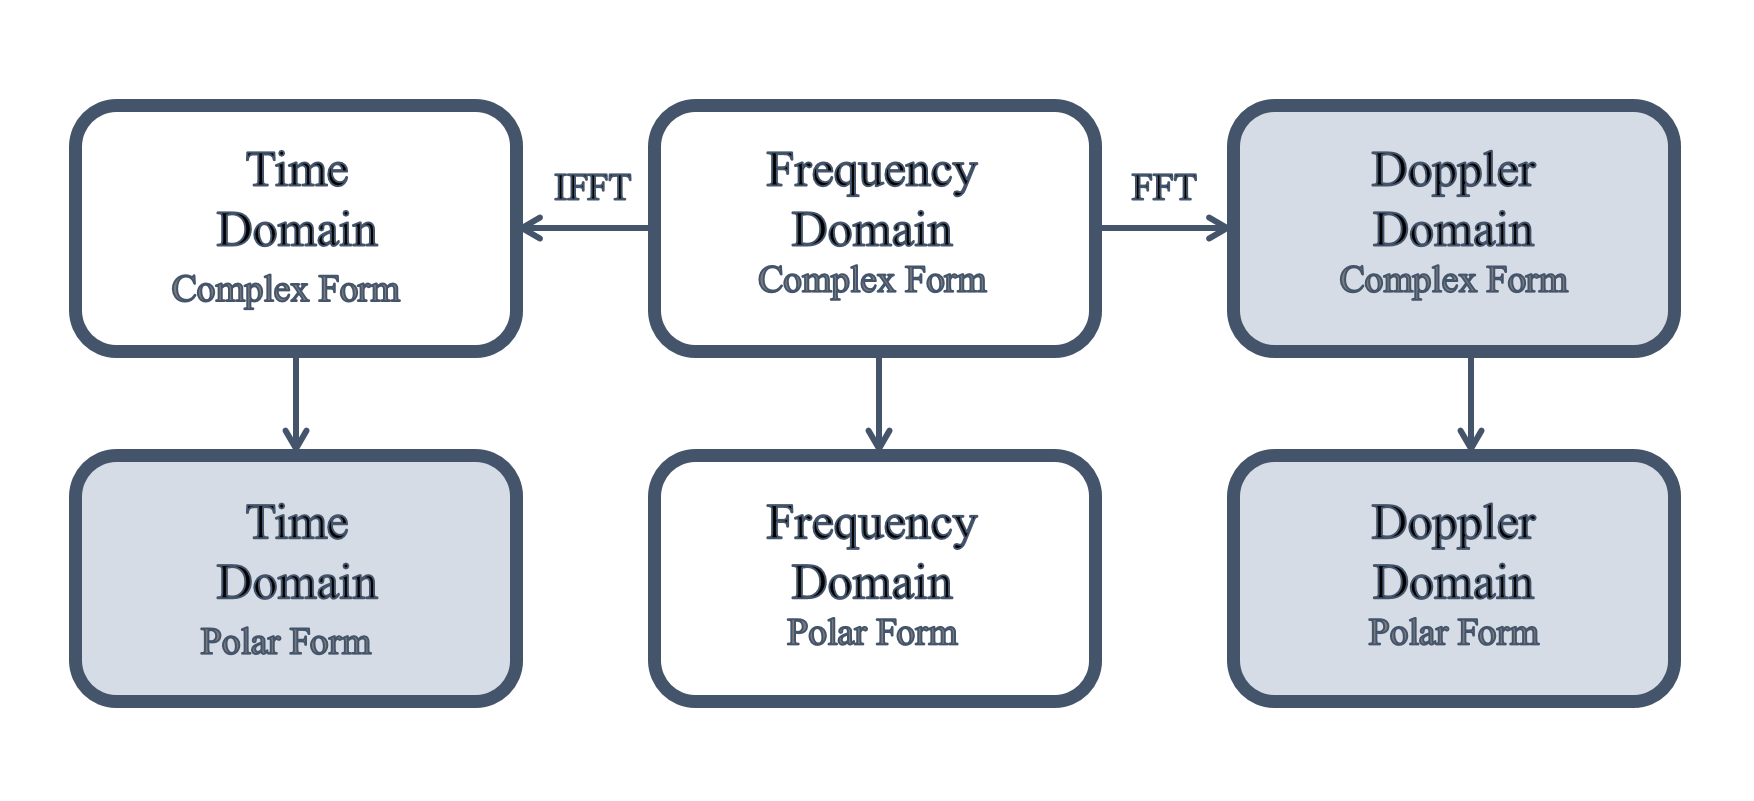



**Domains and their feature names:**

1.   Time (complex, polar): `time_input, time_polar_input`
2.   Frequency (complex, polar): `nn_input, polar_input`     *[Note: nn_input is the main input to the model]*
3.   Doppler (complex, polar): `ddoppler_input, delay_polar_input`


--------------------------

## Models


**Model names**

Model 1: Domain 1+2 | Complex

Model 2: Domain 1+2 | Polar

Model 3: Domain 1+2 | Complex + Polar

<br>

Model 4: Domain 2+3 | Complex

Model 5: Domain 2+3 | Polar

Model 6: Domain 2+3 | Complex + Polar

<br>

Model 7: Domain 1+3 | Complex

Model 8: Domain 1+3 | Polar

Model 9: Domain 1+3 | Complex + Polar

<br>

Model 10: Domain 1+2+3 | Complex

Model 11: Domain 1+2+3 | Polar

Model 12: Domain 1+2+3 | Complex + Polar

Model 13: Domain 1 (complex) + 2 (complex+polar) *(Benchmark)*

Model 14: Domain 1+2+3 | Complex + Polar | Attention *(Our final model)*


In [ ]:
import os
import glob
# import tensorflow_probability as tfp

import numpy as np

import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.layers import Add, Concatenate, Conv3D, Dense, Dropout, Flatten, Input, Lambda, LeakyReLU, Multiply, Reshape
from keras.models import Model




In [ ]:
def CDF_Error_np(Y_pred, Y):
    print(abs(Y-Y_pred).shape)
    error = np.linalg.norm(abs(Y - Y_pred), axis = 1)
    return(error)

#### Set number of epochs

In [ ]:
n_epochs = 50

### Model 0

**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    ifft_real = tf.math.real(ifft)
    fmin_real = tf.reduce_min(ifft_real, axis=0, keepdims=True)
    fmax_real = tf.reduce_max(ifft_real, axis=0, keepdims=True)
    norm_ifft_real = (ifft_real-fmin_real)/(fmax_real-fmin_real)

    ifft_imag = tf.math.imag(ifft)
    fmin_imag = tf.reduce_min(ifft_imag, axis=0, keepdims=True)
    fmax_imag = tf.reduce_max(ifft_imag, axis=0, keepdims=True)
    norm_ifft_imag = (ifft_imag-fmin_imag)/(fmax_imag-fmin_imag)
    #norm_ifft_imag = (ifft_imag-tf.reduce_min(ifft_imag))/(tf.reduce_max(ifft_imag)-tf.reduce_min(ifft_imag))

    return tf.stack([norm_ifft_real, norm_ifft_imag], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 2

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([time_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model 0**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



In [ ]:
model.save('model_0.keras')

In [ ]:
#model_0 = tf.keras.models.load_model('model_0.keras')

# Check its architecture
#model_0.summary()

y_train_pred_0 = model.predict(X_train)
y_test_pred_0 = model.predict(X_test)

loss_0 = CDF_Error_np(y_test_pred_0, y_test)
sorted_loss_0 = np.sort(loss_0)

In [ ]:
sns.ecdfplot(sorted_loss_0, label = 'Freq  | Complex', linestyle = '--')
plt.xlabel('Loss')
plt.ylabel('CDF')
plt.ylim(-0.01, 1.03)
plt.title('Cumulative Distribution Function (CDF) Plot')
plt.grid(True)
plt.legend()
plt.show()

### Model 1


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 4

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([nn_input, time_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 2


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 4

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([polar_input, time_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 3


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 8

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([nn_input, polar_input, time_input, time_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 4


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 4

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([nn_input, ddoppler_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 5


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 4

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([polar_input, delay_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 6


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 8

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([nn_input, polar_input, ddoppler_input, delay_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 7


**Model definition**

In [ ]:
### Utils ###
def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 4

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([time_input, ddoppler_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 8


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 4

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([time_polar_input, delay_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 9


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 8

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([time_input, time_polar_input, ddoppler_input, delay_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 10


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 6

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([nn_input, time_input, ddoppler_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 11


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 6

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([polar_input, time_polar_input, delay_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 12


**Model definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 12

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([nn_input, polar_input, time_input, time_polar_input, ddoppler_input, delay_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()



### Model 13
This captures the CNN baseline from benchmark paper

Features used:
- Complex features in freq domain
- Polar features in freq domain
- Complex features in time domain

**Model** **definition**

In [ ]:
### Utils ###

def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r


def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

### Model definition ###
def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 6

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))


    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())


    ##### POLAR
    polar_input = Concatenate()([r, t])


    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)



    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())


    ### POLAR
    time_polar_input = Concatenate()([s, alpha])


    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())


    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])


    total_input = Concatenate()([nn_input, polar_input, time_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)
    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Concatenate()([layD1, layD2])
    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)
    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Concatenate()([layD2, layD3])
    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)
    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)
    layV1 = Concatenate()([layV1, layD4])
    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    layV2 = Concatenate()([layV2, layV1])
    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])
    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])
    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model

**Build and Compile model**

In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train Model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()


### Model 14

In [ ]:
def k_sqrt(tensor):
    r = K.sqrt(tensor)
    return r

def k_atan(tensor):
    t = tf.math.atan2(tensor[0], tensor[1])
    return t

def fft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    fft = tf.signal.fft(y)
    return tf.stack([tf.math.real(fft), tf.math.imag(fft)], axis=3)

def ifft(x):
    y = tf.complex(x[:, :, :, 0], x[:, :, :, 1])
    ifft = tf.signal.ifft(y)
    return tf.stack([tf.math.real(ifft), tf.math.imag(ifft)], axis=3)

def build_model():
    # Model specifications
    dropout_rate = 0.25
    num_complex_channels = 12

    ########################
    ### FREQUENCY DOMAIN ###
    ########################

    ### COMPLEX
    nn_input = Input((64, 100, 2))

    # mean_input = Lambda(k_mean)(nn_input)
    # print(mean_input.get_shape())

    # complex to polar
    real = Lambda(lambda x: x[:, :, :, 0])(nn_input)
    imag = Lambda(lambda x: x[:, :, :, 1])(nn_input)

    real_squared = Multiply()([real, real])
    imag_squared = Multiply()([imag, imag])

    real_imag_squared_sum = Add()([real_squared, imag_squared])

    # amplitude
    r = Lambda(k_sqrt)(real_imag_squared_sum)
    r = Reshape((64, 100, 1))(r)
    print(r.get_shape())

    # phase
    t = Lambda(k_atan)([imag, real])
    t = Reshape((64, 100, 1))(t)
    print(t.get_shape())

    ##### POLAR
    polar_input = Concatenate()([r, t])

    ###################
    ### TIME DOMAIN ###
    ###################

    ### COMPLEX
    time_input = Lambda(ifft)(nn_input)

    # feat# - 7,8, complex to polar of time domain input
    t_real = Lambda(lambda x: x[:, :, :, 0])(time_input)
    t_imag = Lambda(lambda x: x[:, :, :, 1])(time_input)
    t_real_squared = Multiply()([t_real, t_real])
    t_imag_squared = Multiply()([t_imag, t_imag])
    t_real_imag_squared_sum = Add()([t_real_squared, t_imag_squared])

    s = Lambda(k_sqrt)(t_real_imag_squared_sum) # amplitude
    s = Reshape((64, 100, 1))(s)
    print(s.get_shape())

    alpha = Lambda(k_atan)([t_imag, t_real])    # phase
    alpha = Reshape((64, 100, 1))(alpha)
    print(alpha.get_shape())

    ### POLAR
    time_polar_input = Concatenate()([s, alpha])

    ######################
    ### DOPPLER DOMAIN ###
    ######################

    #feat# -9,10 - doppler domain complex numbers

    ### COMPLEX
    ddoppler_input = Lambda(fft)(nn_input)

    #feat# - 11,12 -polar form of doppler input
    d_real = Lambda(lambda x: x[:, :, :, 0])(ddoppler_input)
    d_imag = Lambda(lambda x: x[:, :, :, 1])(ddoppler_input)
    d_real_squared = Multiply()([d_real, d_real])
    d_imag_squared = Multiply()([d_imag, d_imag])
    d_real_imag_squared_sum = Add()([d_real_squared, d_imag_squared])

    v = Lambda(k_sqrt)(d_real_imag_squared_sum) # amplitude
    v = Reshape((64, 100, 1))(v)
    print(v.get_shape())

    gamma = Lambda(k_atan)([d_imag, d_real])    # phase
    gamma = Reshape((64, 100, 1))(gamma)
    print(gamma.get_shape())

    ### POLAR
    delay_polar_input = Concatenate()([v, gamma])

    total_input = Concatenate()([nn_input, polar_input, time_input, time_polar_input, ddoppler_input, delay_polar_input])
    print("total", total_input.get_shape())

    # reduce dimension of time axis
    lay_input = Reshape((64, 100, num_complex_channels, 1))(total_input)

    # Attention
    layD1 = Conv3D(8, (1, 23, num_complex_channels), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal')(lay_input)
    layD1 = LeakyReLU(alpha=0.3)(layD1)
    layD1 = Dropout(dropout_rate)(layD1)

    layD2 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD1)
    layD2 = LeakyReLU(alpha=0.3)(layD2)

    # Attention
    attention_d = AdditiveAttention()([layD1, layD2])
    layD2 = Concatenate()([layD1, attention_d])

    layD2 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD2)
    layD2 = LeakyReLU(alpha=0.3)(layD2)
    layD2 = Dropout(dropout_rate)(layD2)

    layD3 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD2)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    # layD3 = Concatenate()([layD2, layD3])

    # Attention
    attention_d2 = AdditiveAttention()([layD2, layD3])
    layD3 = Concatenate()([layD2, attention_d2])

    layD3 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Conv3D(8, (1, 23, 1), strides=(1, 5, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layD3)
    layD3 = LeakyReLU(alpha=0.3)(layD3)
    layD3 = Dropout(dropout_rate)(layD3)

    layD4 = Conv3D(8, (1, 23, 1), padding="same",kernel_initializer='glorot_normal')(layD3)
    layD4 = LeakyReLU(alpha=0.3)(layD4)
    layD4 = Concatenate()([layD4, layD3])
    layD4 = Conv3D(8, (1, 1, num_complex_channels), padding="same",kernel_initializer='glorot_normal')(layD4)
    layD4 = LeakyReLU(alpha=0.3)(layD4)

    # Vn Layers with Attention
    layV1 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layD4)
    layV1 = LeakyReLU(alpha=0.3)(layV1)
    layV1 = Dropout(dropout_rate)(layV1)

    # layV1 = Concatenate()([layV1, layD4])

    layV2 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01))(layV1)
    layV2 = LeakyReLU(alpha=0.3)(layV2)
    layV2 = Dropout(dropout_rate)(layV2)
    # layV2 = Concatenate()([layV2, layV1])
    print("layV1.shape, layV2.shape", layV1.shape, layV2.shape)
    # Apply attention
    attention_v = Attention()([layV1, layV2])


    layV2 = Concatenate()([layV2, attention_v])

    layV3 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV2)
    layV3 = LeakyReLU(alpha=0.3)(layV3)
    layV3 = Dropout(dropout_rate)(layV3)
    layV3 = Concatenate()([layV3, layV2])

    layV4 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV3)
    layV4 = LeakyReLU(alpha=0.3)(layV4)
    layV4 = Dropout(dropout_rate)(layV4)
    layV4 = Concatenate()([layV4, layV3])

    layV5 = Conv3D(8, (8, 1, 1), padding="same",kernel_initializer='glorot_normal')(layV4)
    layV5 = LeakyReLU(alpha=0.3)(layV5)
    layV5 = Dropout(dropout_rate)(layV5)

    nn_output = Flatten()(layV5)
    nn_output = Dense(1024, activation="relu")(nn_output) #extra layer added
    nn_output = Dense(64, activation="relu")(nn_output)
    nn_output = Dense(32, activation="relu")(nn_output)
    nn_output = Dense(2, activation="linear")(nn_output)
    model = Model(inputs=nn_input, outputs=nn_output)
    model.compile(optimizer="Adam", loss="mse")
    model.summary()
    return model


In [ ]:
tf.random.set_seed(0)
model = build_model()

**Train Model**

In [ ]:
# Model fit
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

**View prediction**

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
plt.scatter(y_train[:,0],y_train[:,1], label = "GT")
plt.scatter(y_train_pred[:,0],y_train_pred[:,1], label = "Pred")
plt.legend()
plt.title('Train set')
plt.show()

plt.scatter(y_test[:,0],y_test[:,1], label = "GT")
plt.scatter(y_test_pred[:,0],y_test_pred[:,1], label = "Pred")

plt.legend()
plt.title('Test set')
plt.show()


-----